# CatBoost

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from catboost import CatBoostClassifier, Pool
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_contour, plot_slice
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

from model_utils import calc_gini_coef, plot_roc_curve

In [2]:
from model_utils import split_dataset_v2

FEATURES_PATH = '../data/features_selected/features_v6_rfe_lgb_v4.csv'

X_train, X_valid, X_test, y_train, y_valid, y_test = split_dataset_v2(FEATURES_PATH, valid_size=0.2, replace_special_symbols=True)

## Hyperparameter tuning

## Bayesian Optimization

In [68]:
ALPHA = 0.25  # used for penalizing gap between train and validation score

def objective(trial):

    params = {
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'iterations': trial.suggest_int('iterations', 800, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.015, 0.05),
        'depth': trial.suggest_int('depth', 2, 4),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 5.0, 50.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 2.0),
        'random_strength': trial.suggest_float('random_strength', 2.0, 3.0),
        'bootstrap_type': 'Bayesian',
        'verbose': False,
        'random_seed': 42,
        'thread_count': 6,
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = CatBoostClassifier(**params)
        model.fit(X_tr, y_tr)

        y_tr_pred_proba = model.predict_proba(X_tr)[:, 1]
        y_va_pred_proba = model.predict_proba(X_va)[:, 1]

        tr_gini = calc_gini_coef(y_tr, y_tr_pred_proba)
        va_gini = calc_gini_coef(y_va, y_va_pred_proba)

        score = va_gini - ALPHA * (tr_gini - va_gini)
        scores.append(score)

    return np.mean(scores)

In [ ]:
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)

study.optimize(objective, n_trials=200)

In [51]:
print('Best score:', study.best_value)
print('Best params:', study.best_params)

Best score: 0.6065093138561493
Best params: {'iterations': 1050, 'learning_rate': 0.0343885064597434, 'depth': 3, 'l2_leaf_reg': 32.62070927424568, 'bagging_temperature': 1.0252997821424992, 'random_strength': 2.798432525304949}


In [52]:
plot_optimization_history(study)

In [53]:
plot_parallel_coordinate(study)

In [54]:
plot_slice(study)

In [55]:
plot_param_importances(study)

## Model training and evaluation

In [72]:
# Bayesian optimization
model = CatBoostClassifier(
    **study.best_params,
    loss_function='Logloss',
    eval_metric='AUC',
    bootstrap_type='Bayesian',
    verbose=False,
    random_seed=42,
    thread_count=6,
)

In [81]:
# Bayesian optimization hardcoded
model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    iterations=1178,
    learning_rate=0.03184734149419872,
    depth=3,
    l2_leaf_reg=47.286088087855134,
    bagging_temperature=1.2889514813555372,
    random_strength=2.718342864504448,
    bootstrap_type='Bayesian',
    verbose=False,
    random_seed=42,
    thread_count=6,
)

In [82]:
model.fit(X_train, y_train)

In [89]:
# y_true = y_train
# y_pred_proba = model.predict_proba(X_train)[:, 1]
# y_true = y_valid
# y_pred_proba = model.predict_proba(X_valid)[:, 1]
y_true = y_test
y_pred_proba = model.predict_proba(X_test)[:, 1]

Gini Coefficient:  0.612202760135518


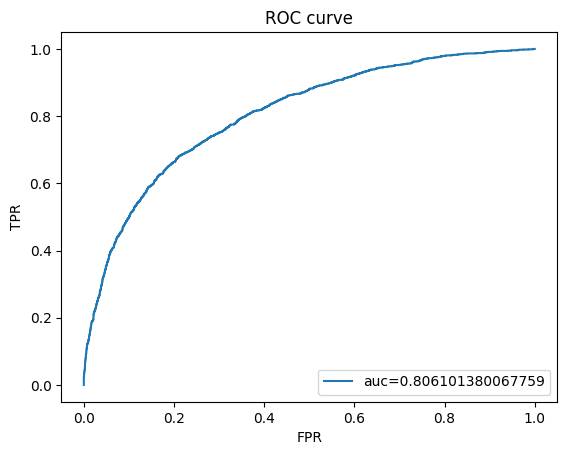

In [90]:
gini_coef = calc_gini_coef(y_true, y_pred_proba)
print('Gini Coefficient: ', gini_coef)

plot_roc_curve(y_true, y_pred_proba)

## Feature importance

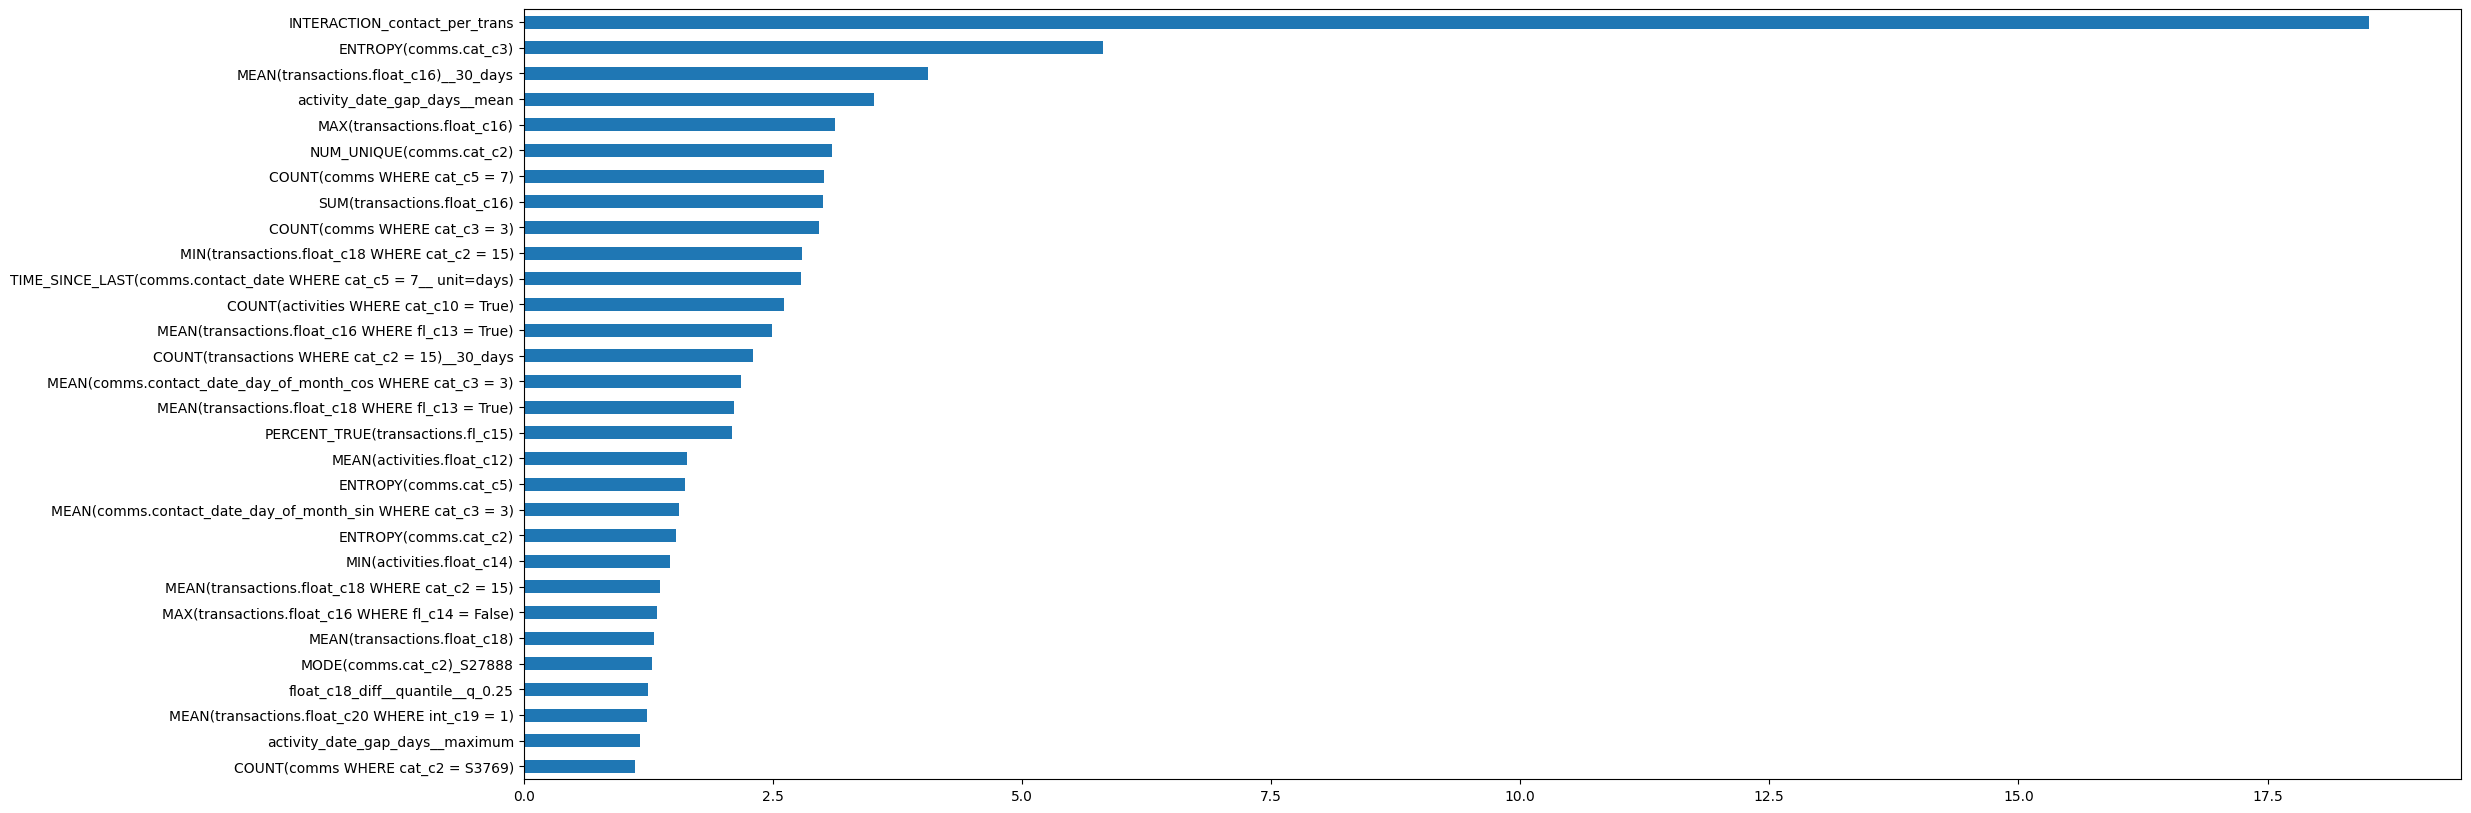

In [91]:
importances = model.get_feature_importance(type='PredictionValuesChange')
features_importance = pd.Series(importances, index=X_valid.columns).sort_values(ascending=False)
features_importance.head(30).iloc[::-1].plot(kind='barh', figsize=(25, 10))
plt.show()

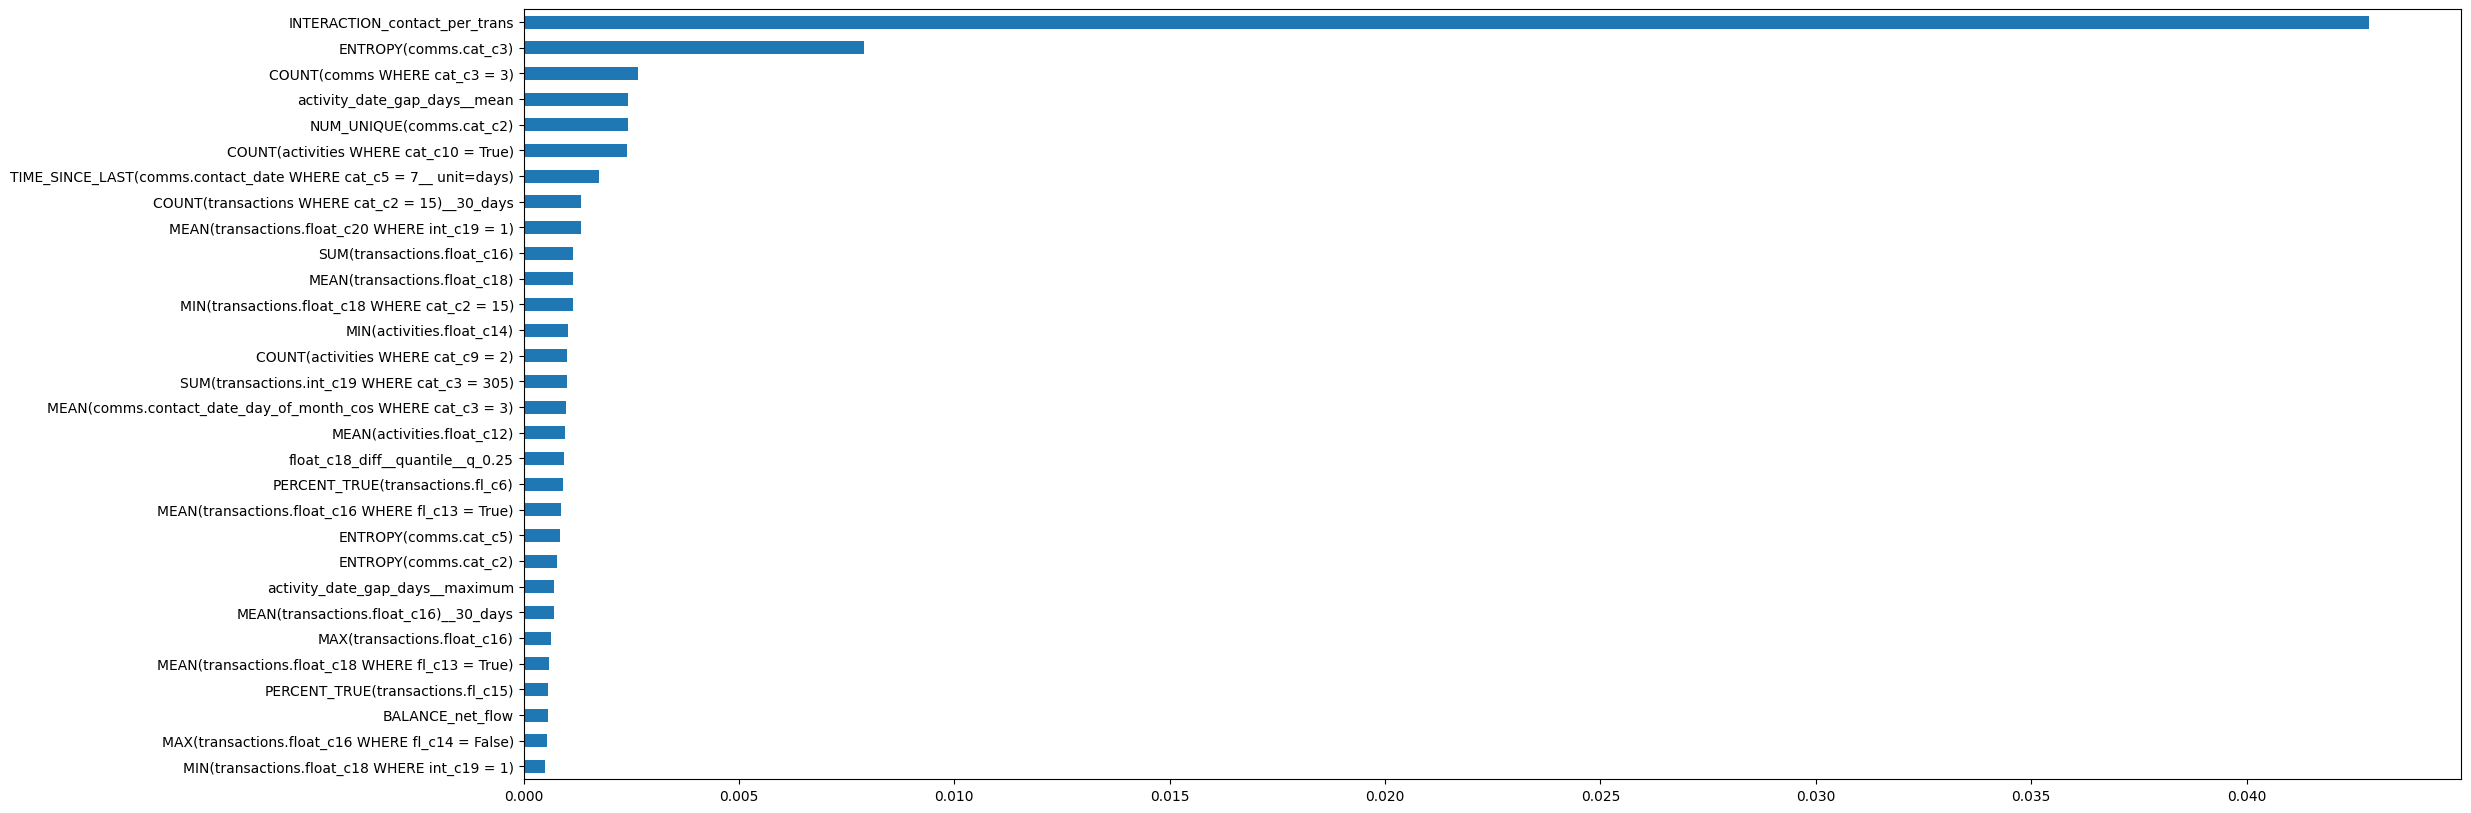

In [92]:
importances = model.get_feature_importance(data=Pool(X_valid, y_valid), type='LossFunctionChange')
features_importance = pd.Series(importances, index=X_valid.columns).sort_values(ascending=False)
features_importance.head(30).iloc[::-1].plot(kind='barh', figsize=(25, 10))
plt.show()